In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.19/5947/1 Dashboard: http://localhost:38326/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [4]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [10]:
# Importing MHW observation files
localDir = "/g/data1a/e14/rm6294/matlab_trial/"
# Want obs from lon: 90 to 210, lat: (+- ?)10 to -50 (not sure if I should go to +10 or -10)
mhws = xr.open_mfdataset(localDir + 'mhw_severity.pc90.*-50to-30*.nc')['severity']
mhws = mhws.sel(time = slice('1990-01-01', '2008-12-31'))
mhws = mhws.chunk({'time' : t_chunk, 'lat' : y_chunk, 'lon' : x_chunk})

In [11]:
# Importing MHW model files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')
pastMHW = pastMHW.isel(y = slice(5,120), x = slice(110, 330))
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

Index: 
* Max Severity 
* Max SSTA 
* Number of MHW Days 

## Finding mean of the max severity per year in model and observational MHWs
This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the top of the model, which seemed to give some weird results.

In [12]:
%%time
maxSev = mhws.groupby('time.year').max(dim = 'time').mean(dim = 'year').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


CPU times: user 3.79 s, sys: 993 ms, total: 4.79 s
Wall time: 2.96 s


In [13]:
# Replaces land masses with nan as opposed to 0 value
maxSev = xr.where(maxSev == 0, np.nan, maxSev)

In [14]:
# Same as above
maxPastSev = pastMHW.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

In [15]:
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)

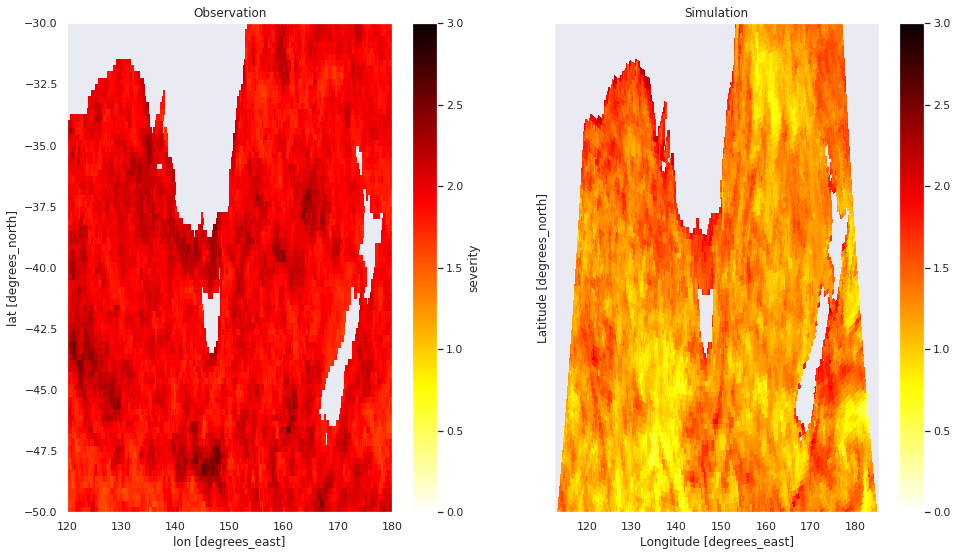

In [16]:
f, ax = plt.subplots(1, 2, sharey = True)
vmin = 0; vmax = 3;
maxSev.plot(cmap = 'hot_r', vmin = vmin, vmax = vmax, ax = ax[0]);
maxPastSev.plot(cmap = 'hot_r', vmin = vmin, vmax = vmax, ax = ax[1], x = 'nav_lon', y = 'nav_lat');
ax[0].set_title('Observation')
ax[1].set_title('Simulation');

### Histogram

In [20]:
y1 = np.linspace(0,1.9)
y2 = np.linspace(0,3)

# Calculates the median for simulation
median_sim = maxPastSev.median().data
# Creates a time series that can be used alongside a histogram to show the change in median
median_series_sim = np.full_like(y1, median_sim)

# Calculates the median for observations
median_obvs = maxSev.median().data
# Creates a time series that can be used alongside a histogram to show the change in median
median_series_obvs = np.full_like(y2, median_obvs)

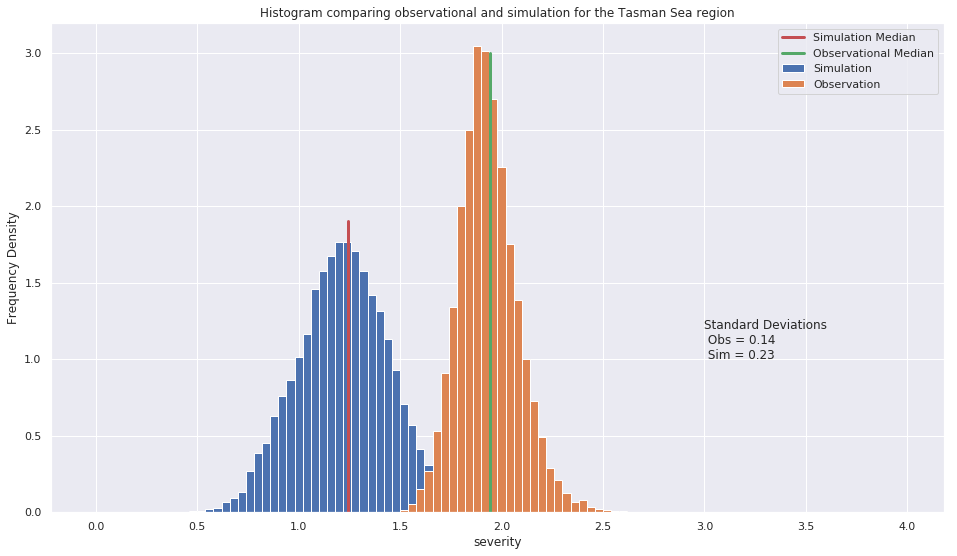

In [21]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,4,101)
# True if plotting densities, false if you want just frequency
pltDens = True

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Simulation')
maxSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Observation')

plt.plot(median_series_sim, y1, 'r',label = 'Simulation Median', linewidth = 3)
plt.plot(median_series_obvs, y2, 'g',label = 'Observational Median', linewidth = 3)

plt.title('Histogram comparing observational and simulation for the Tasman Sea region')
plt.ylabel('Frequency Density')
plt.legend()

std_obvs = np.round(maxSev.std().data,2)
std_sim = np.round(maxPastSev.std().data,2)
std_str = ('Standard Deviations\n Obs = {0:.2} \n Sim = {1:.2}').format(std_obvs, std_sim)
plt.text(3.0, 1, std_str);

## Max SSTA

In [80]:
ssta = xr.open_mfdataset(localDir + 'mhw_severity.pc90.*-50to-30*.nc')['ssta']
ssta = ssta.chunk({'time' : 365, 'lat' : 80, 'lon' : 60})

In [81]:
ssta

<xarray.DataArray 'ssta' (time: 13673, lat: 80, lon: 240)>
dask.array<shape=(13673, 80, 240), dtype=float32, chunksize=(365, 80, 60)>
Coordinates:
  * lat      (lat) float32 -49.875 -49.625 -49.375 ... -30.625 -30.375 -30.125
  * time     (time) datetime64[ns] 1981-08-30 1981-08-31 ... 2019-02-04
  * lon      (lon) float64 120.1 120.4 120.6 120.9 ... 179.1 179.4 179.6 179.9
Attributes:
    units:      degrees C
    long_name:  Daily sea surface temperature anomaly

In [82]:
%%time
# Finding max SSTA
maxSSTA = ssta.groupby('time.year').max(dim = 'time').mean(dim = 'year').compute() 

CPU times: user 9.64 s, sys: 858 ms, total: 10.5 s
Wall time: 7.65 s


In [84]:
# Replaces land masses with nan as opposed to 0 value
maxSSTA = xr.where(maxSSTA == 0, np.nan, maxSSTA)

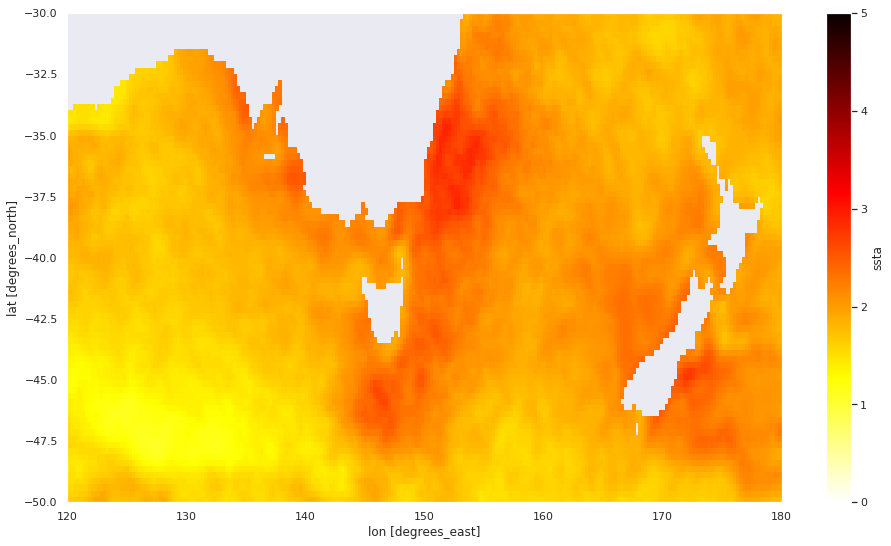

In [85]:
vmin, vmax = (0, 5)
maxSSTA.plot(cmap = 'hot_r', vmin = vmin, vmax = vmax);
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSSTAPerYear')

### Histogram 

In [94]:
# Calculates the median the area weights future and past SSTA
median_ssta = maxSSTA.median().data
# Creates a time series that can be used alongside a histogram to show the change in median
y = np.linspace(0,1.5)
median_ssta_series = np.full_like(y, median_ssta)

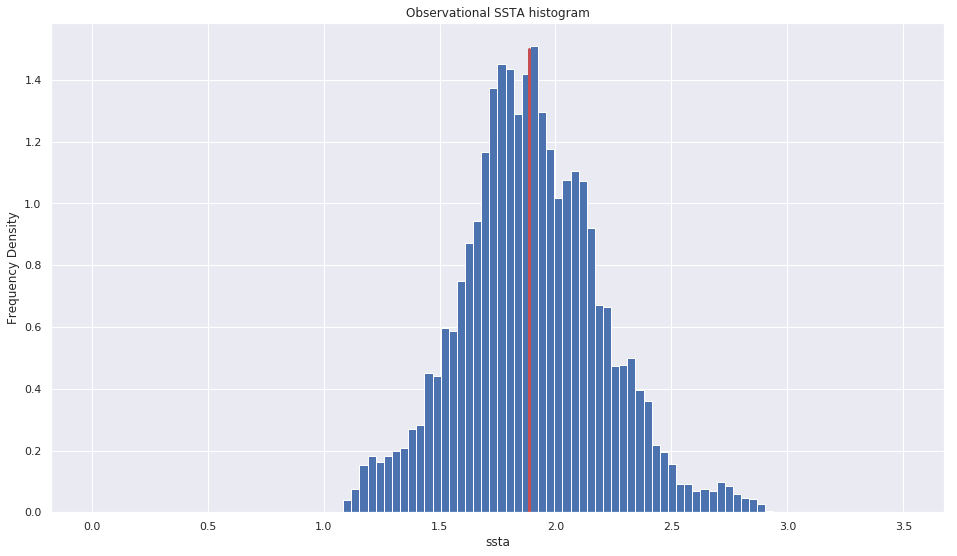

In [99]:
# Plots the frequencies/frequency density for each SSTA. 
bins = np.linspace(0, 3.5, 101)

# True if plotting densities, false if you want just frequency
pltDens = True
maxSSTA.plot.hist(bins = bins, density = pltDens)
plt.ylabel('Frequency Density')
plt.title('Observational SSTA histogram')

# Plotting medians
plt.plot(median_ssta_series, y, 'r',label = 'Median', linewidth = 3);

#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSSTAPerYear_hist')

## Counting number of MHW days 

In [101]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
days = xr.where(mhws > 0, 1, 0).sum('time')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
days = xr.where(days == 0, np.nan, days).compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


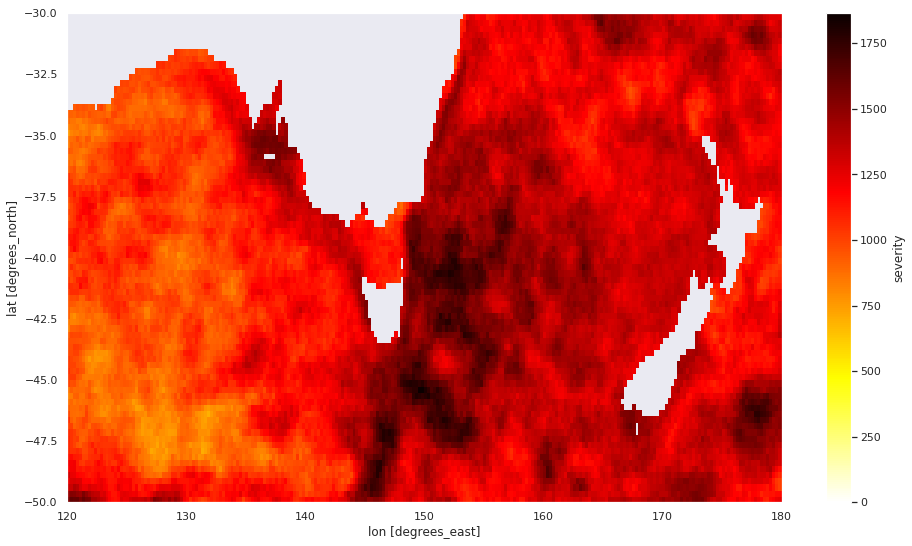

In [103]:
vmin, vmax = (0, 1000)
days.plot(vmin = vmin, cmap = 'hot_r');

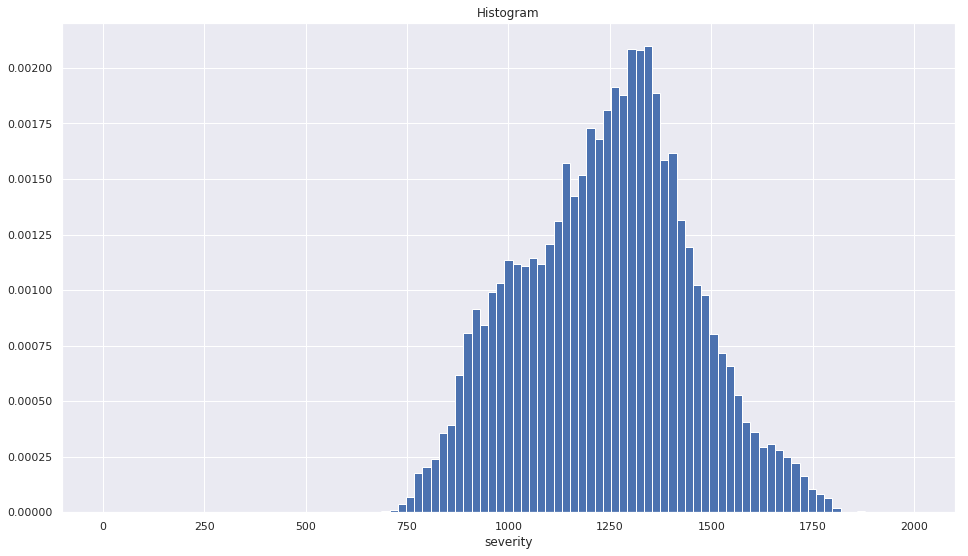

In [106]:
# Plots the frequencies/frequency density for # of days. 
bins = np.linspace(0,2000,100)

# True if plotting densities, false if you want just frequency
pltDens = True

days.plot.hist(align = 'mid', density = pltDens, bins = bins);